In [1]:
from IPython.display import HTML
HTML('''<script>
code_show=false; 
function code_toggle() {
 if (code_show){
 $('div.input').hide();
 } else {
 $('div.input').show();
 }
 code_show = !code_show
} 
$( document ).ready(code_toggle);
</script>
<b>Note:</b> the raw code for this notebook is by default hidden for easier reading.
To toggle the code on/off, click <a href="javascript:code_toggle()">here</a>.''')

# Setup

In [2]:
import torch
import Darwin as dw
import seaborn as sns

from torchvision import datasets, transforms
from bogus import atk
from ipywidgets  import interactive, fixed
from bokeh.io import output_notebook

output_notebook()
sns.set()

Loading BokehJS ...

In [3]:
with open(r"D:\TELEGRAM_BOTS\NEURALUPDATES.txt") as file: #Credentials for telegram bot
    telegram_credentials = file.read().split('\n')

In [4]:
transform = transforms.Compose([
                       transforms.ToTensor()])

MNIST_train = datasets.MNIST(r'D:\Data_sets/MNIST', 
                            train=True, download=True,
                            transform=transform)

MNIST_test = datasets.MNIST(r'D:\Data_sets/MNIST', 
                            train=False, download=True,
                            transform=transform)

train_loader = torch.utils.data.DataLoader(
                            MNIST_train, batch_size=64, 
                            shuffle=True, pin_memory=True)

test_loader = torch.utils.data.DataLoader(MNIST_test,
                            batch_size=1000, shuffle=True, 
                            pin_memory=True)

In [5]:
NET_SPACE = {
    'nb_layers': {'lb': 1, 'ub': 3, 'mutate': 0.15},
    'lr': {'lb': 0.001, 'ub':0.1, 'mutate': 0.15},
    'weight_decay': {'lb': 0.00001, 'ub': 0.0004, 'mutate':0.2},
    'optimizer': {'func': ['sgd', 'adam', 'adadelta','rmsprop'], 'mutate': 0.2}
}

In [6]:
LAYER_SPACE = {
    'nb_units':{'lb': 128, 'ub':2048, 'mutate': 0.15},
    'dropout_rate': {'lb': 0.0, 'ub': 0.7, 'mutate': 0.2},
    'activation': {'func': ['relu'], 'mutate':0.2}
                   #['linear','tanh','relu','sigmoid','elu'], 'mutate':0.2}
}

In [7]:
atk_func = atk()

# Run 

In [8]:
testing = dw.TournamentOptimizer(3, LAYER_SPACE, NET_SPACE, dw.randomize_network, 
                           dw.mutate_net, dw.NetFromBuildInfo, dw.train, dw.test,
                          train_loader, test_loader, atk_func.fgsm, telegram_credentials)

In [9]:
testing.step(generations=1, epochs=1, save=True, phone=False)

Generation 1 Population mean:151.66666666666666 max:429

Top performers:
0: score:429
1: score:26



# Plots

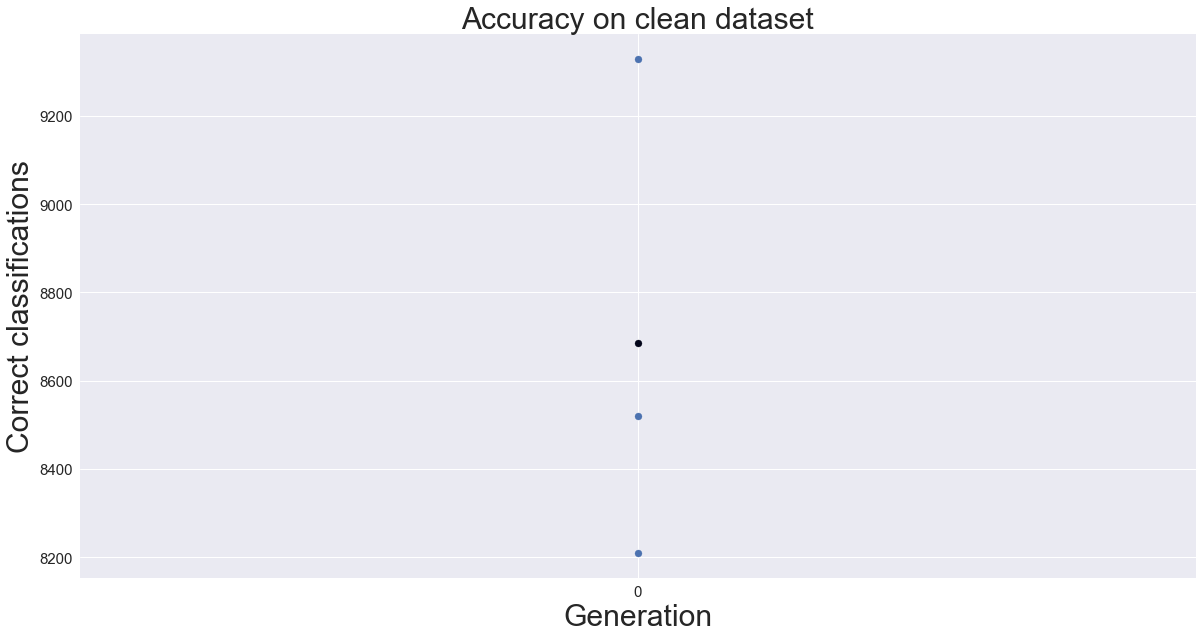

In [10]:
dw.progressplotter(testing, clean=True)

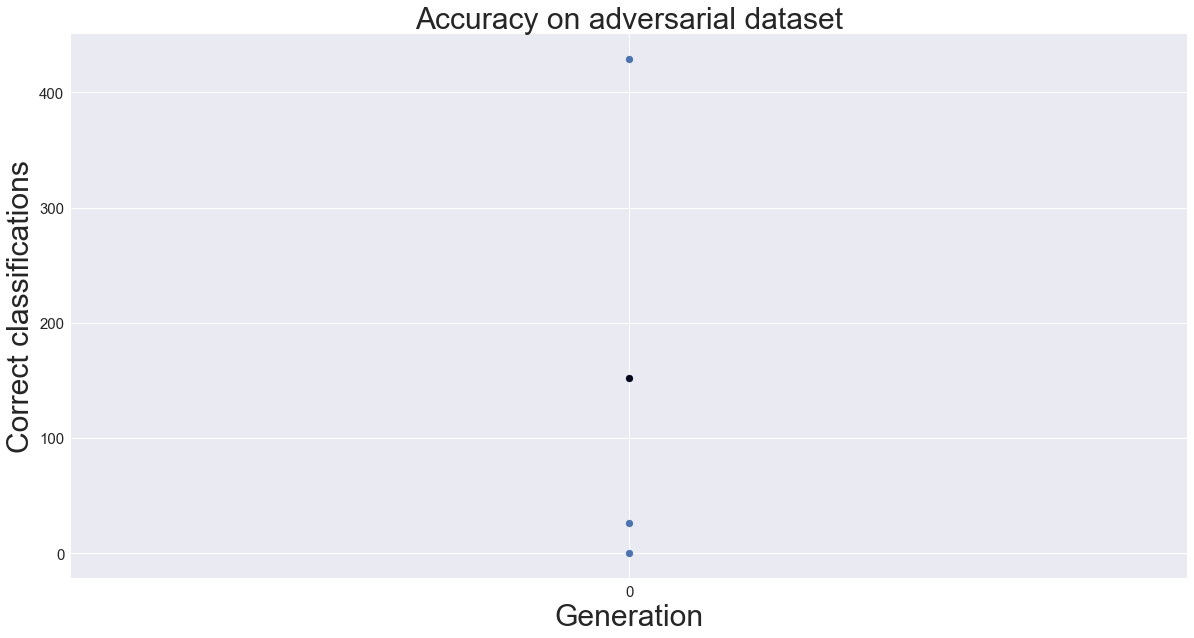

In [11]:
dw.progressplotter(testing)

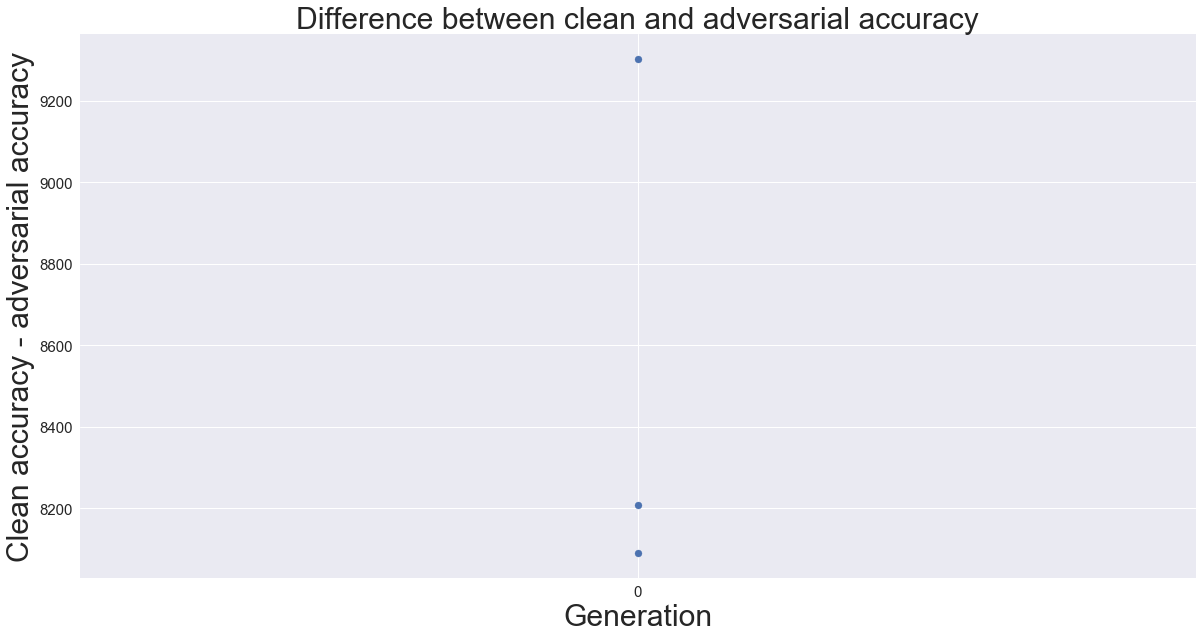

In [12]:
dw.diffplotter(testing)

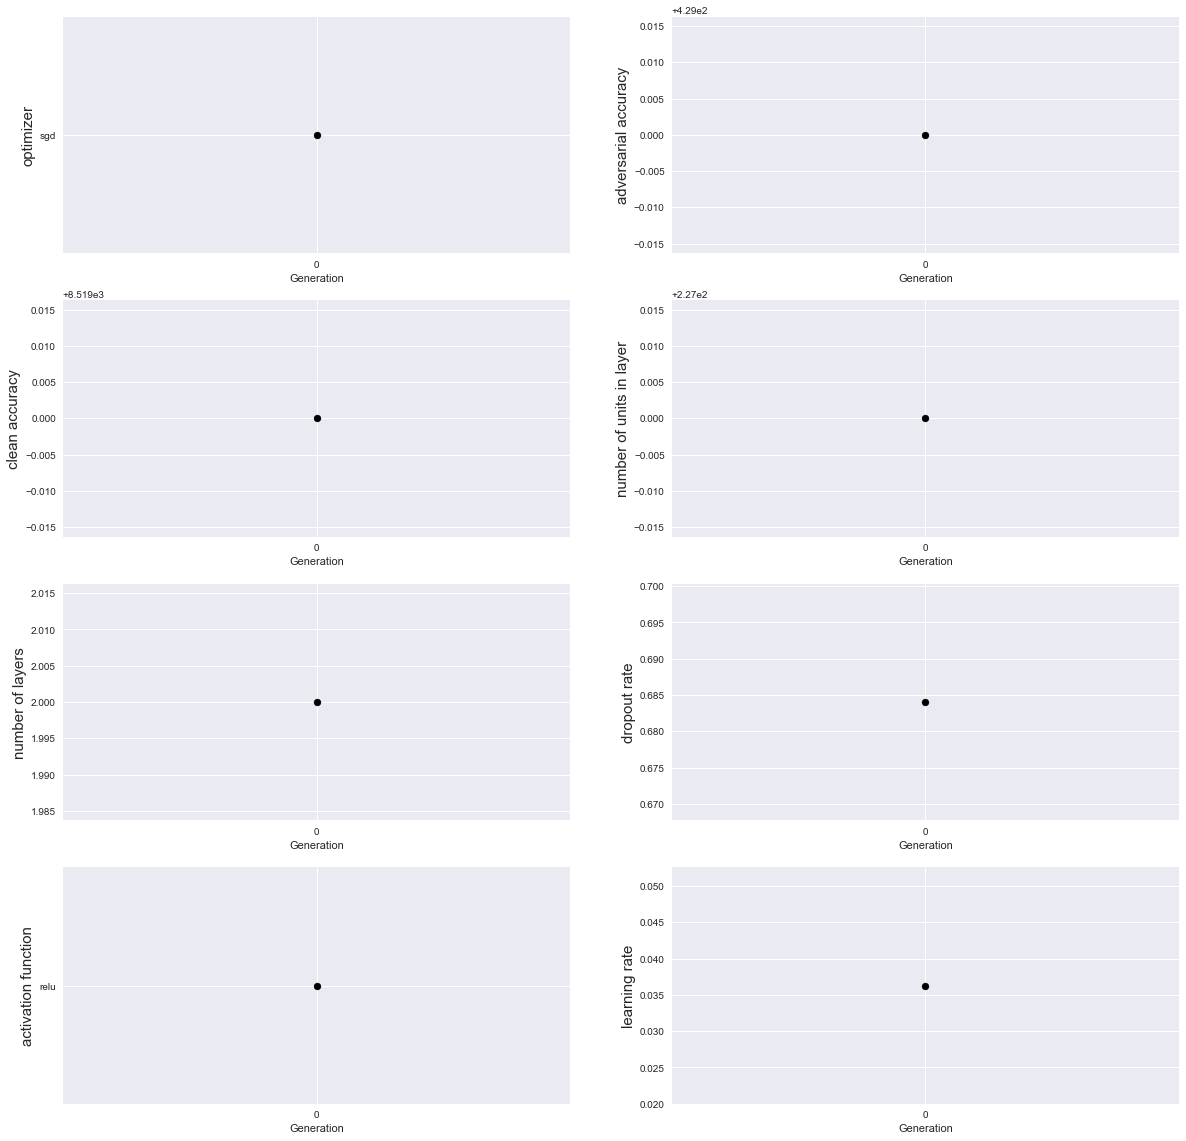

In [13]:
dw.bestplotter(testing, k=0)

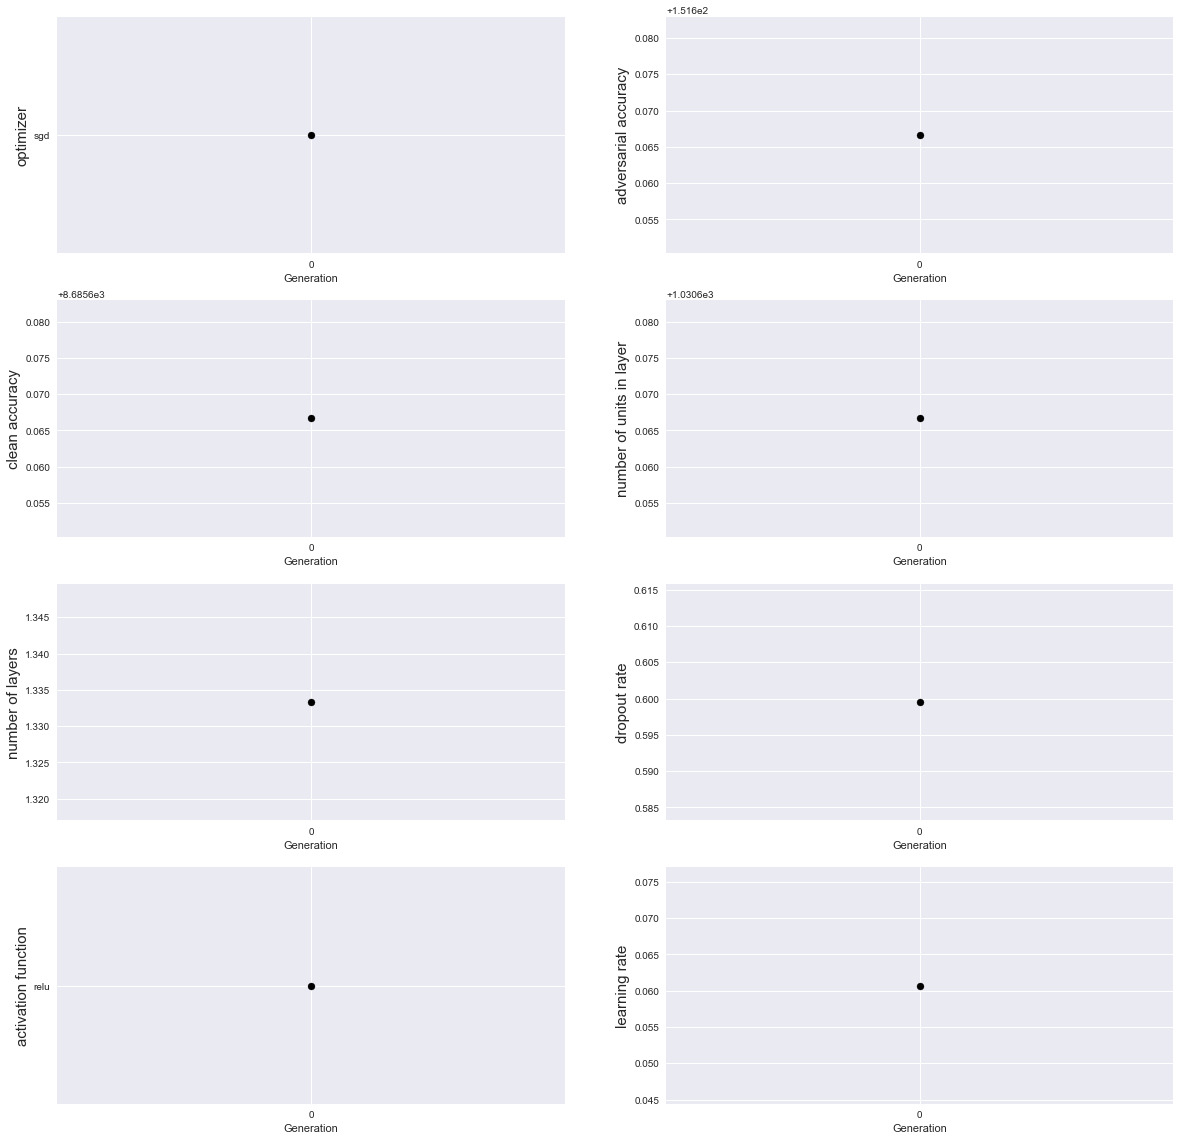

In [14]:
dw.avgplotter(testing)

In [15]:
dw.best_printer(testing)

,adversarial,clean,generation
best_adversarial,429,8519,1
best_clean,26,9329,1


Showing best model which was found in generation 1
Clean accuracy = 8519
adversarial accuracy =429

Model: 

 NetFromBuildInfo(
  (model): Sequential(
    (flatten): Flatten()
    (fc_0): Linear(in_features=784, out_features=227, bias=True)
    (dropout_0): Dropout(p=0.6840343874299387)
    (relu0): ReLU()
    (fc_1): Linear(in_features=227, out_features=1365, bias=True)
    (dropout_1): Dropout(p=0.35448497266488477)
    (relu1): ReLU()
    (logits): Linear(in_features=1365, out_features=10, bias=True)
    (softmax): Softmax()
  )
) 

 Images below are adversarial
[[1.4801321e-07 1.5445172e-10 1.4827244e-09 1.1099709e-10 4.4563767e-12
  5.2906375e-07 2.7499908e-08 2.8161255e-14 9.9999928e-01 2.7969460e-10]]
[[4.5479217e-07 8.7510617e-11 6.2835403e-07 9.9984622e-01 1.1849849e-11
  7.5822704e-06 3.8316644e-10 1.3755482e-11 1.4509310e-04 5.0422053e-09]]
[[1.3248100e-15 3.0100415e-33 4.1933258e-12 2.3482293e-28 5.3082108e-29
  1.7243236e-21 1.0000000e+00 1.9618179e-44 3.4140026e-24 1.7652

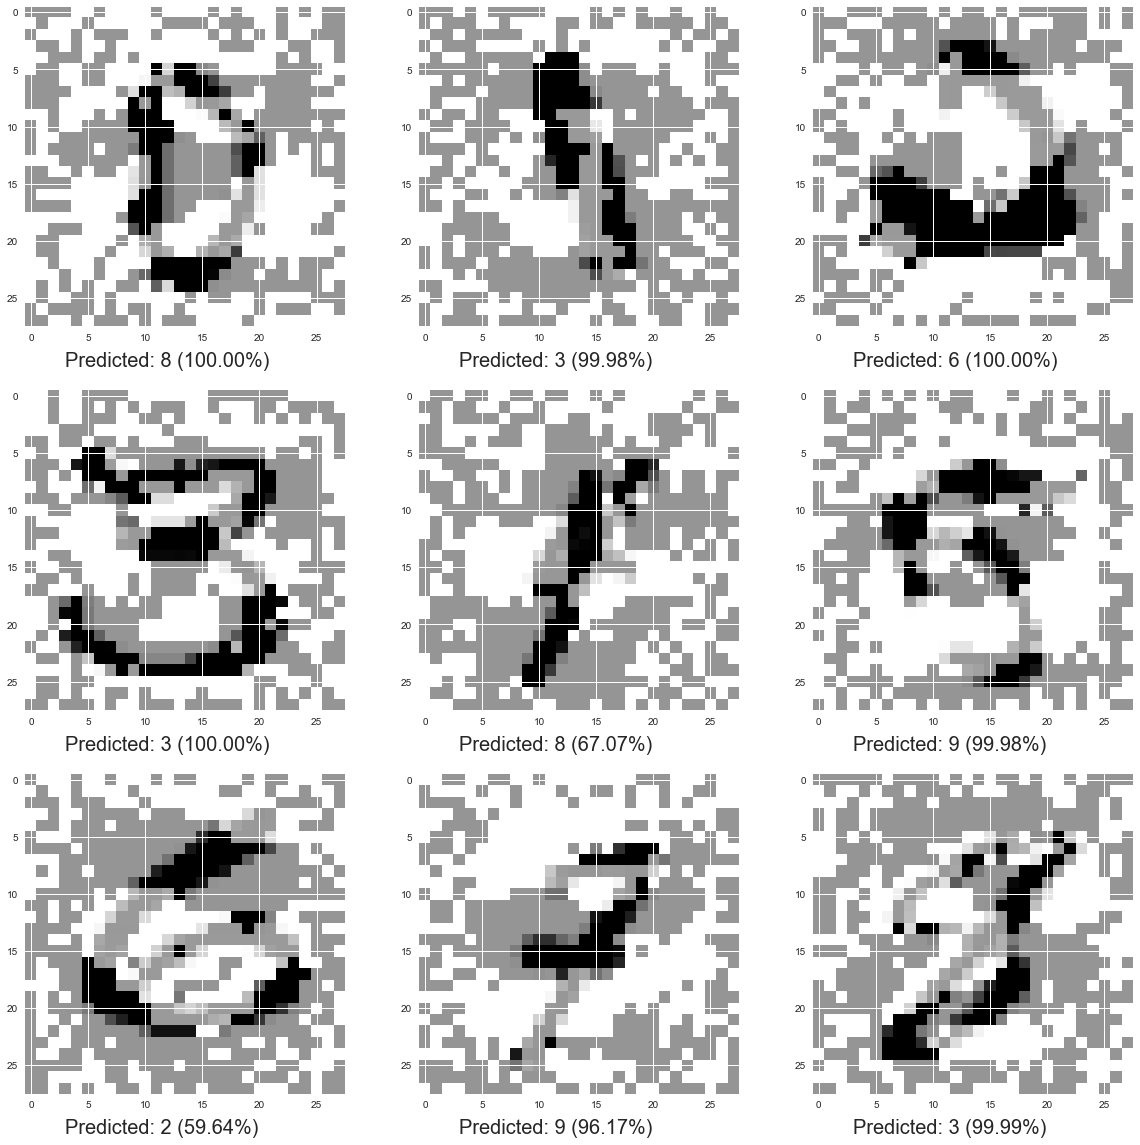

In [16]:
dw.multi_plot(testing, test_loader, adv_func=atk_func.fgsm, adversarial=True, eps=0.5)

Showing best model which was found in generation 1
Clean accuracy = 8519
adversarial accuracy =429

Model: 

 NetFromBuildInfo(
  (model): Sequential(
    (flatten): Flatten()
    (fc_0): Linear(in_features=784, out_features=227, bias=True)
    (dropout_0): Dropout(p=0.6840343874299387)
    (relu0): ReLU()
    (fc_1): Linear(in_features=227, out_features=1365, bias=True)
    (dropout_1): Dropout(p=0.35448497266488477)
    (relu1): ReLU()
    (logits): Linear(in_features=1365, out_features=10, bias=True)
    (softmax): Softmax()
  )
) 

 Images below are clean
[[5.1074147e-01 3.0734770e-10 9.8977040e-04 4.8587757e-01 6.5131624e-12
  3.6229804e-04 9.1833270e-09 1.3275337e-07 2.0288269e-03 7.7567730e-09]]
[[1.5917036e-16 9.9999976e-01 4.0693987e-08 3.9747483e-10 3.2831158e-15
  1.7042957e-10 1.2770716e-11 5.9234388e-11 2.0561370e-07 5.9159578e-13]]
[[4.6123733e-13 3.5949317e-16 9.9999976e-01 9.2636690e-16 6.2573341e-17
  3.1096358e-12 2.1649060e-07 2.9396725e-19 6.4759065e-13 7.9276325e-2

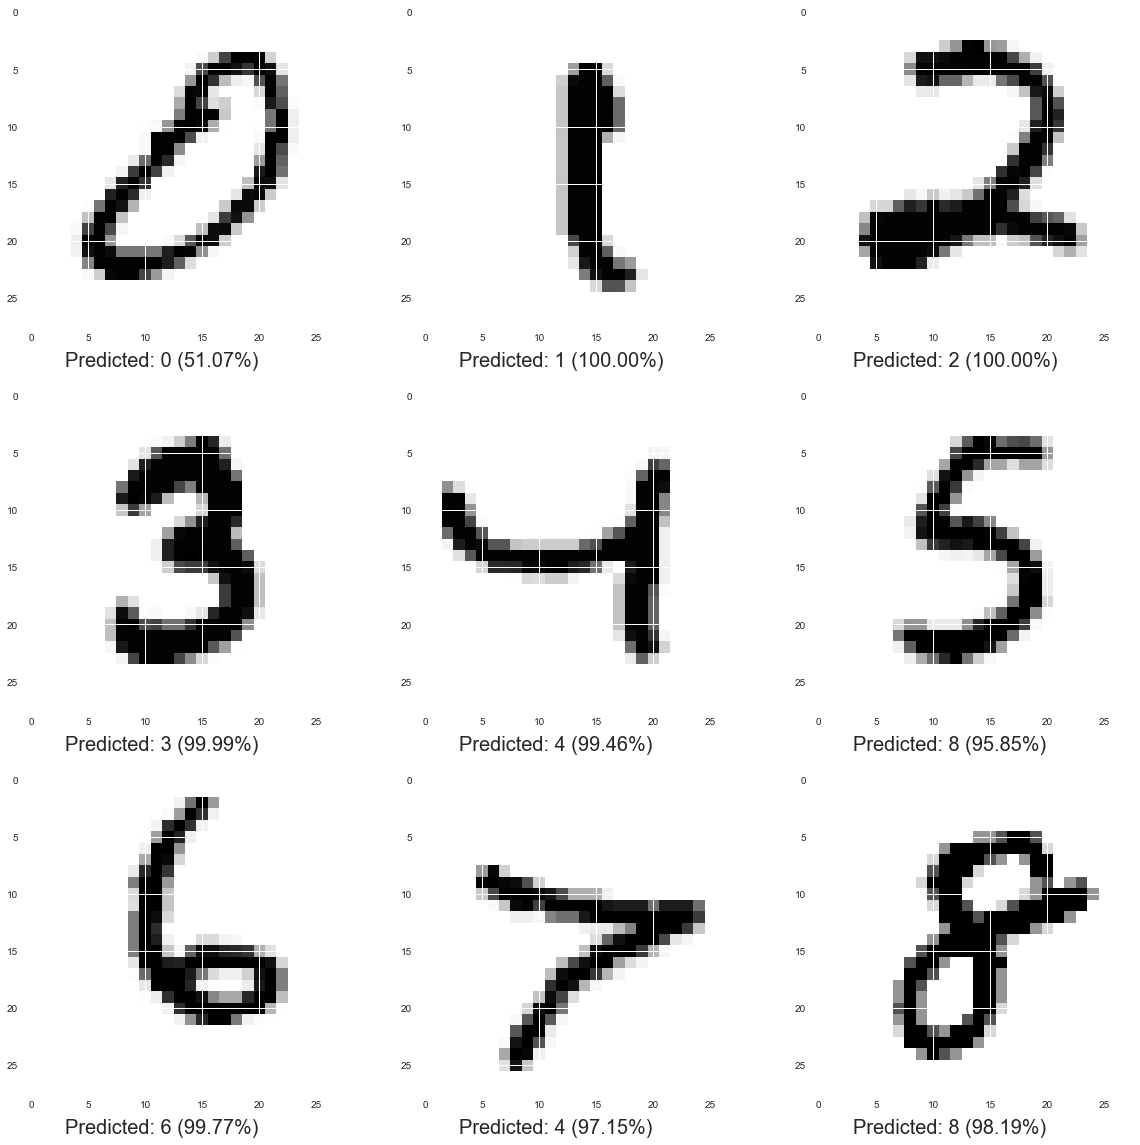

In [17]:
dw.multi_plot(testing, test_loader, adversarial=False)

In [18]:
df = dw.dataframer(testing)
#df.to_pickle(r"../data/neuroevolution4")

In [19]:
opts = df.columns.tolist()[:-1] #last column contains dicts which causes bokeh to fail
gen_opts = ['all'] + df['Generation'].unique().tolist() 
y1_opts = opts[2:] + opts[:2]
y2_opts = opts[1:] + opts[:1]
interactive_plot = interactive(dw.int_plot, df=fixed(df), x=opts, y=y1_opts, x2=opts, y2=y2_opts, gen=gen_opts)

In [20]:
interactive_plot #bokeh does not show on Github due to JS restrictions

interactive(children=(Dropdown(description='x', options=('Generation', 'Clean', 'Adversarial', 'No_layers', 'L…

In [ ]:
dw.multi_plot()

In [ ]:
dw.rebuild_from_save()

In [21]:
model = dw.get_best_model(testing)[3]

In [22]:
model

NetFromBuildInfo(
  (model): Sequential(
    (flatten): Flatten()
    (fc_0): Linear(in_features=784, out_features=227, bias=True)
    (dropout_0): Dropout(p=0.6840343874299387)
    (relu0): ReLU()
    (fc_1): Linear(in_features=227, out_features=1365, bias=True)
    (dropout_1): Dropout(p=0.35448497266488477)
    (relu1): ReLU()
    (logits): Linear(in_features=1365, out_features=10, bias=True)
    (softmax): Softmax()
  )
)

In [23]:
import torch.nn.functional as F
from torch.autograd import Variable
import matplotlib.pyplot as plt
import numpy as np

In [24]:
batch = next(iter(test_loader))
img = batch[0][0].data
label = batch[1][0]

In [25]:
img.size()

torch.Size([1, 28, 28])

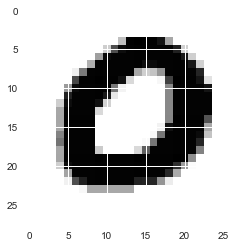

In [26]:
plt.imshow(img.numpy().reshape(28,28), cmap='Greys')

In [27]:
label

tensor(0)

In [28]:
grads = {}

In [29]:
def save_grad(name):  #closure for use as a hook in fgsm attack - otherwise gradients can't be obtained for images. 
    def hook(grad):
        grads[name] = grad
    return hook

In [30]:
grads['grad'].size()

KeyError: 'grad'

In [ ]:
x = Variable(img, requires_grad=True).cuda()

In [ ]:
x.register_hook(save_grad('grad'))

In [ ]:
h_adv = model(x)

In [ ]:
h_adv.shape

In [ ]:
criterion = torch.nn.CrossEntropyLoss()

In [ ]:
cost = criterion(h_adv, labels.cuda().view(1))

In [ ]:
cost.backward()

In [ ]:
h_adv

In [ ]:
h_adv[0].detach().cpu().numpy()

In [ ]:
np.exp(-215449.73)

In [ ]:
def fgsm(model, x, y, eps=0.3, x_val_min=0, x_val_max=1): #https://arxiv.org/pdf/1412.6572.pdf
        
    x_adv = Variable(x.data, requires_grad=True).cuda() #clean image
    x_adv.register_hook(self.save_grad('x_adv'))

    h_adv = model(x_adv) #clean pred

    cost = F.nll_loss(h_adv, y.cuda()) #negative log loss clean image and clean pred

    if x_adv.grad is not None:
        x_adv.grad.data.fill_(0)

    cost.backward()

    x_adv = x_adv + (eps*self.grads['x_adv'].sign())
    x_adv = torch.clamp(x_adv, x_val_min, x_val_max)


    return x_adv

In [ ]:
for data, target in test_loader:
    data, target = data.cuda(), target.cuda()
    data= adv_func(model, data, target, eps=eps)
    output = model(data)
    pred = output.max(1, keepdim=True)[1]
    correct += pred.eq(target.view_as(pred).cuda()).sum().item()
    test_loss += F.nll_loss(output, target, size_average=False).item()